In [1]:
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
%matplotlib inline

In [2]:
df = pd.read_csv("./data/quotes-BTC.csv")
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E
2,2015-02-06-003563,AmEx needs to get into Bitcoin or one of the o...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E
3,2015-03-25-030626,I have to learn to work as part of a team and ...,Mat Jackson,['Q5825983'],2015-03-25 08:56:14,1,"[['Mat Jackson', '0.7861'], ['None', '0.2139']]",['http://www.autosport.com/news/report.php/id/...,E
4,2015-06-22-017667,If each bitcoin has a history and people know ...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E


In [3]:
# Check the unique value in the phase column
# And drop the column if there is only one value in the column
if len(df.phase.unique()) == 1:
    print("column 'phase' only contains 1 unqiue value, thus drop")
    df.drop(columns=["phase"], inplace=True)
  

# Check whether all the name are actually unique (lower and upper letter)
# Convert column 'speaker' to lower case
if len(df["speaker"].unique()) !=  len(df["speaker"].str.lower().unique()):
    print("Detect same name with letter in both lower and upper case, thus all lower case")
    df["speaker"] = df["speaker"].str.lower()


column 'phase' only contains 1 unqiue value, thus drop
Detect same name with letter in both lower and upper case, thus all lower case


In [4]:
# Transform column "date": downs to date
# Preverse "year" column to facilitate later access
df["year"]  = pd.DatetimeIndex(df.date).year
df["month"] = pd.DatetimeIndex(df.date).month
df["day"]   = pd.DatetimeIndex(df.date).day
df["date"]  = pd.to_datetime(df[["year", "month", "day"]])
df.drop(columns=["month", "day"], inplace=True)

In [5]:
# Generate frequency of quotations over date
occurrence = df.groupby(df.date)["quotation"].count().to_frame()

# Compute a 14-day rolling average
occurrence['rolling_occ'] = occurrence['quotation'].rolling(14).mean()

occurrence.tail()

,quotation,rolling_occ
date,,
2020-04-12,5,5.857143
2020-04-13,5,6.142857
2020-04-14,5,6.000000
2020-04-15,4,5.642857
2020-04-16,4,5.571429


In [6]:
# Stats of occurrence
occurrence["quotation"].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
quotation,1694.0,14.256198,15.656057,1.0,5.0,10.0,18.0,163.0


Text(0.5, 1.0, 'Frequency of BTC-related quotations from 2015 to 2020')

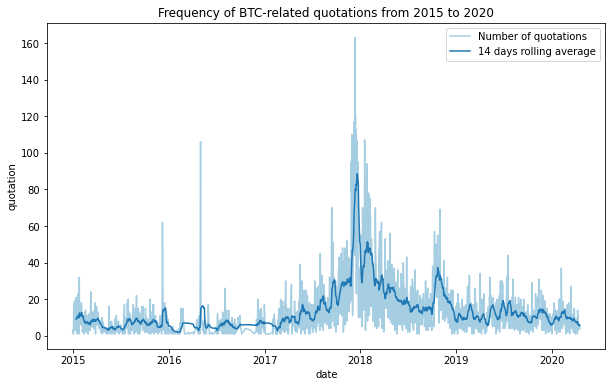

In [7]:
plt.figure(figsize=[10,6])
sns.set_palette("Paired")
sns.lineplot(data=occurrence, x= "date", y="quotation", label="Number of quotations")
sns.lineplot(data=occurrence, x= "date", y="rolling_occ", label="14 days rolling average")
plt.title("Frequency of BTC-related quotations from 2015 to 2020")

In [8]:
df_with_speaker = df[df.speaker != 'none']

# df_with_speaker[df_with_speaker.speaker=="Roger Ver"]
# We observed that the "speaker" "qids" pairs are unique throughout the dataset

df_freq_speaker = df_with_speaker.groupby(["speaker", "qids"], as_index=False)["quotation"].count()\
                    .sort_values(by=['quotation'], ascending=False)

print("There are {} speaker who have made BTC-related statements in the dataset".format(len(df_freq_speaker)))
df_freq_speaker.head(5)

There are 4114 speaker who have made BTC-related statements in the dataset


,speaker,qids,quotation
3862,tom lee,"['Q16233960', 'Q29425405', 'Q7816555']",325
3379,roger ver,['Q19600251'],196
1631,jamie dimon,['Q922169'],193
778,craig wright,"['Q21686827', 'Q5181620', 'Q965883']",171
476,bobby lee,"['Q1064120', 'Q18606917', 'Q4935279', 'Q561918...",171


In [9]:
df_freq_speaker.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
quotation,4114.0,4.038162,12.180655,1.0,1.0,1.0,3.0,325.0


From the statistics in the table above, we know that the mean of # Quotation is around 4 per speaker, while 3 quartile is 3 quotations, which means speakers who made over 3 quotations only consists of approx. 25% of all the speakers, with a maximum of 325 quotations. Thus, the data follows a heavy-tail distribution, and we will dive deeper into it.

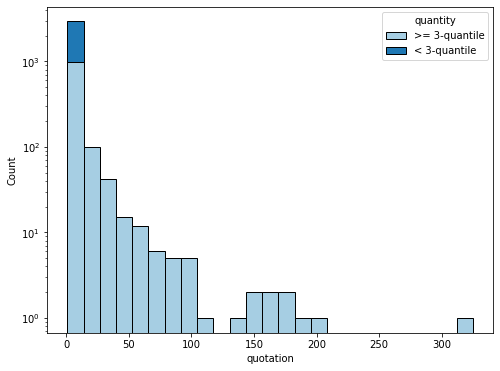

In [10]:
# Create a new column to compare against 3-quantile
df_freq_speaker["quantity"] = np.where(df_freq_speaker['quotation'] >= 3, ">= 3-quantile", "< 3-quantile")

plt.figure(figsize=[8,6])
sns.histplot(df_freq_speaker, x ='quotation', hue="quantity", bins=25, alpha=1)
plt.yscale('log')

In [11]:
# Check whether column qids is string representation of list
# And convert it to type list if it is to facilitate later access
if type(df_freq_speaker["qids"][0]) == str:
    print("column 'qids' is of type str, thus convert to list")
    df_freq_speaker["qids"] = df_freq_speaker["qids"].apply( lambda row: json.loads(row.replace("'", '"')) )
    
df_freq_speaker.head()

column 'qids' is of type str, thus convert to list


,speaker,qids,quotation,quantity
3862,tom lee,"[Q16233960, Q29425405, Q7816555]",325,>= 3-quantile
3379,roger ver,[Q19600251],196,>= 3-quantile
1631,jamie dimon,[Q922169],193,>= 3-quantile
778,craig wright,"[Q21686827, Q5181620, Q965883]",171,>= 3-quantile
476,bobby lee,"[Q1064120, Q18606917, Q4935279, Q56191801]",171,>= 3-quantile


## Process speaker attribute data

In [12]:
speaker_attribute = pd.read_parquet("./Project datasets/speaker_attributes.parquet")

In [13]:
# Drop columns that are not needed
speaker_attribute.drop(columns=["aliases", "lastrevid", "US_congress_bio_ID", "party", "type", "religion", "candidacy"], inplace=True)

# Convert label to lower letter
speaker_attribute["label"] = speaker_attribute["label"].str.lower()

In [14]:
speaker_attribute.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label
0,[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],None,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",None,Q23,george washington
1,[+1952-03-11T00:00:00Z],[Q145],[Q6581097],[Q7994501],"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,Q42,douglas adams
2,[+1868-08-23T00:00:00Z],[Q31],[Q6581097],None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,Q1868,paul otlet
3,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",None,Q207,george w. bush
4,[+1599-06-06T00:00:00Z],[Q29],[Q6581097],None,[Q1028181],None,Q297,diego velázquez


In [15]:
# Get unique qids of speakers to subset the speaker_attribute dataframe
nested_qids = df_freq_speaker.qids.tolist()
flat_list = [item for elem in nested_qids for item in elem]
unique_qids = np.unique(flat_list).tolist()

In [16]:
speaker_attribute = speaker_attribute[speaker_attribute.id.isin(unique_qids)]
speaker_attribute.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label
18,[+1950-09-17T00:00:00Z],[Q668],[Q6581097],"[Q1282294, Q6889284]","[Q82955, Q36180, Q7019111, Q10429346]",None,Q1058,narendra modi
222,[+1938-08-15T00:00:00Z],[Q30],[Q6581097],None,"[Q185351, Q16533, Q40348, Q1622272, Q82955]",None,Q11124,stephen breyer
347,[+1997-06-21T00:00:00Z],[Q30],[Q6581072],None,"[Q177220, Q33999, Q55960555, Q2405480, Q171252...",None,Q18804,rebecca black
371,[+1955-02-24T00:00:00Z],[Q30],[Q6581097],None,"[Q131524, Q205375, Q81096, Q5322166, Q82594, Q...",None,Q19837,steve jobs
400,[+1924-10-01T00:00:00Z],[Q30],[Q6581097],None,"[Q10669499, Q193391, Q6625963, Q82955, Q131512...",None,Q23685,jimmy carter


In [17]:
# Reformat speaker_attribute dataset

# Extract year-month-date from data_of_birth
boolean_list = speaker_attribute["date_of_birth"].notnull()
speaker_attribute.loc[boolean_list, "date_of_birth"] = \
speaker_attribute.loc[boolean_list, "date_of_birth"].astype(str).str.strip("[]'+Z").str.split("T").str[0]

speaker_attribute.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label
18,1950-09-17,[Q668],[Q6581097],"[Q1282294, Q6889284]","[Q82955, Q36180, Q7019111, Q10429346]",None,Q1058,narendra modi
222,1938-08-15,[Q30],[Q6581097],None,"[Q185351, Q16533, Q40348, Q1622272, Q82955]",None,Q11124,stephen breyer
347,1997-06-21,[Q30],[Q6581072],None,"[Q177220, Q33999, Q55960555, Q2405480, Q171252...",None,Q18804,rebecca black
371,1955-02-24,[Q30],[Q6581097],None,"[Q131524, Q205375, Q81096, Q5322166, Q82594, Q...",None,Q19837,steve jobs
400,1924-10-01,[Q30],[Q6581097],None,"[Q10669499, Q193391, Q6625963, Q82955, Q131512...",None,Q23685,jimmy carter


We have observed **anomaly** that month must be in 1..12, whereas there are occurrences where month is '00', thus we are going to investigate why this is the case.

In [18]:
# Show anomaly
speaker_attribute[speaker_attribute.date_of_birth.str.split("-").str[1] == '00']

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label
18598,1978-00-00,[Q30],[Q6581097],None,"[Q5322166, Q483501]",None,Q491536,dennis hwang
56303,1950-00-00,[Q96],[Q6581097],None,[Q13141064],None,Q1687711,victor jaramillo
63410,1965-00-00,[Q145],[Q6581097],None,"[Q13141064, Q28143257]",None,Q1933021,mike adams
72801,1969-00-00,[Q145],[Q6581097],None,"[Q1930187, Q482980, Q36180]",None,Q2440127,tom standage
123690,1968-00-00,None,[Q6581097],None,None,None,Q4665700,abdul salam
...,...,...,...,...,...,...,...,...
8487425,1924-00-00,None,[Q6581097],None,[Q193391],None,Q56817037,eric young
8487427,1933-00-00,None,[Q6581097],None,[Q193391],None,Q56817085,derek white
8495279,1929-00-00,None,[Q6581097],None,[Q193391],None,Q57392216,michael j. brown
8499812,1946-00-00,None,[Q6581097],None,[Q193391],None,Q57832814,david madden


As can be seen from the table above, there are 599 data entries with anomaly data of birth. That is, month and date are all '00', which might indicate that the month and date of their birth is actually unknown. However, as the specific month and date of one's birth is not important to us, we decide to preserve only year of birth.

In [19]:
# Preserve only year of birth
speaker_attribute["date_of_birth"] = speaker_attribute.date_of_birth.str.split("-").str[0]

In [20]:
# Calculate the percentage of missing value in each column
speaker_attribute.isnull().sum() / len(speaker_attribute)

date_of_birth      0.289900
nationality        0.271488
gender             0.033106
ethnic_group       0.970877
occupation         0.140480
academic_degree    0.988847
id                 0.000000
label              0.000000
dtype: float64

The above statistics are the missing value rate

In [21]:
df_freq_speaker[["speaker", "quotation"]]

,speaker,quotation
3862,tom lee,325
3379,roger ver,196
1631,jamie dimon,193
778,craig wright,171
476,bobby lee,171
...,...,...
2128,kathleen clark,1
2129,katie hopkins,1
2131,kavita jain,1
2136,keith davies,1


In [22]:
# Add the quotation column via merging two dataframe
speaker_data = pd.merge(
    speaker_attribute, 
    df_freq_speaker[["speaker", "quotation"]], 
    left_on = "label",
    right_on = "speaker",
    how = "left")

# Drop redundent column
speaker_data.drop(columns = ["label"], inplace = True)
speaker_data.head()


,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,speaker,quotation
0,1950,[Q668],[Q6581097],"[Q1282294, Q6889284]","[Q82955, Q36180, Q7019111, Q10429346]",None,Q1058,narendra modi,8.0
1,1938,[Q30],[Q6581097],None,"[Q185351, Q16533, Q40348, Q1622272, Q82955]",None,Q11124,stephen breyer,4.0
2,1997,[Q30],[Q6581072],None,"[Q177220, Q33999, Q55960555, Q2405480, Q171252...",None,Q18804,rebecca black,1.0
3,1955,[Q30],[Q6581097],None,"[Q131524, Q205375, Q81096, Q5322166, Q82594, Q...",None,Q19837,steve jobs,2.0
4,1924,[Q30],[Q6581097],None,"[Q10669499, Q193391, Q6625963, Q82955, Q131512...",None,Q23685,NaN,NaN


In [23]:
# Validate the result of merging
in_quotebank = set(df_freq_speaker.speaker.unique())
in_wiki = set(speaker_data[speaker_data.speaker.notnull()].speaker.unique())

# Display rows where speakers not in merged dataset
not_found_in_wiki = list(in_quotebank.difference(in_wiki))
not_found_df = df_freq_speaker[df_freq_speaker.speaker.isin(not_found_in_wiki)]
not_found_df

,speaker,qids,quotation,quantity
3824,tim draper,[Q7807093],162,>= 3-quantile
3476,samson mow,[Q16974376],88,>= 3-quantile
2037,joseph stiglitz,[Q18430],43,>= 3-quantile
2449,mark karpeles,[Q15890426],29,>= 3-quantile
1251,fred schebesta,[Q20740862],25,>= 3-quantile
...,...,...,...,...
2067,jp smith,[Q21622923],1,< 3-quantile
2074,judge judy,[Q2660811],1,< 3-quantile
458,"bloomberg , michael",[Q607],1,< 3-quantile
2150,ken mahoney,[Q6388068],1,< 3-quantile


We have observed another **anomaly** that 260 speakers in quotebank dataset does not match any name in wikidata, we will investigate a bit further into this. Firstly, we will evaluate whether we can afford this loss.

In [24]:
# Aggregate the sum of quotation numbers w.r.t. quantile
not_found_stat = not_found_df.groupby(['quantity']).agg({'quotation': 'sum'})

# Calculate percentage
not_found_stat["Ratio"] = not_found_stat.quotation / df_freq_speaker.groupby(['quantity']).agg({'quotation': 'sum'}).quotation
not_found_stat

,quotation,Ratio
quantity,,
< 3-quantile,226,0.061884
>= 3-quantile,841,0.064887


As can be seem from the above statistics, approx. 6.5% of quotations will not be used if we ignore this issue, which is too much considering we are doing topic modelling. Besides, there are speaker who mentioned BTC quite frequently, e.g. Tim Draper with 162 quotations, which might indicates he is an expert in this field. Thus, if we ignore this issue, we might miss some important information. In summary, we cannot afford this, and we will see how we can address the issue.

Take Tim Draper as an example, let's see whether this guy is really not included in wikidata.

In [25]:
df_freq_speaker[df_freq_speaker.speaker == 'tim draper']

,speaker,qids,quotation,quantity
3824,tim draper,[Q7807093],162,>= 3-quantile


In [26]:
speaker_attribute[speaker_attribute.label.str.contains("draper")]

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label
5767484,1966,[Q16],[Q6581097],None,[Q11774891],None,Q3801314,tom draper
5864932,1958,[Q30],[Q6581097],None,[Q43845],None,Q7807093,timothy c. draper


Through this experiment, we can actually found Tim Draper in the dataset, with the same id, thus we will re-do the aforementioned merging on the column (q-)id.

In [27]:
# Explode each list in the  "qids" column
df_freq_speaker = df_freq_speaker.explode(column=['qids'])

speaker_data = pd.merge(
    speaker_attribute, 
    df_freq_speaker[["qids", "quotation"]], 
    left_on = "id",
    right_on = "qids",
    how = "left")

# Drop redundent column
speaker_data.drop(columns = ["qids"], inplace = True)
speaker_data.head()


,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label,quotation
0,1950,[Q668],[Q6581097],"[Q1282294, Q6889284]","[Q82955, Q36180, Q7019111, Q10429346]",None,Q1058,narendra modi,8
1,1938,[Q30],[Q6581097],None,"[Q185351, Q16533, Q40348, Q1622272, Q82955]",None,Q11124,stephen breyer,4
2,1997,[Q30],[Q6581072],None,"[Q177220, Q33999, Q55960555, Q2405480, Q171252...",None,Q18804,rebecca black,1
3,1955,[Q30],[Q6581097],None,"[Q131524, Q205375, Q81096, Q5322166, Q82594, Q...",None,Q19837,steve jobs,2
4,1924,[Q30],[Q6581097],None,"[Q10669499, Q193391, Q6625963, Q82955, Q131512...",None,Q23685,jimmy carter,2


In [28]:
# Validate the result of merging
in_quotebank = set(df_freq_speaker.qids.unique())
in_wiki = set(speaker_data.id.unique())

# Display rows where id not in merged dataset
not_found_in_wiki = list(in_quotebank.difference(in_wiki))
not_found_df = df_freq_speaker[df_freq_speaker.qids.isin(not_found_in_wiki)]
not_found_df

,speaker,qids,quotation,quantity
476,bobby lee,Q56191801,171,>= 3-quantile
534,brian kelly,Q48773396,152,>= 3-quantile
3476,samson mow,Q16974376,88,>= 3-quantile
1680,jay clayton,Q57432267,37,>= 3-quantile
1251,fred schebesta,Q20740862,25,>= 3-quantile
...,...,...,...,...
2188,kevin turner,Q55196717,1,< 3-quantile
2101,justin wu,Q33190515,1,< 3-quantile
2062,joswell valdez,Q37993388,1,< 3-quantile
2063,josé rodríguez,Q16875125,1,< 3-quantile


So far we have made an improvement by merging with qid as the size of not_found records decreased from 260 to 158. Moveover, as we are performing exploding on the dataframe where one speaker may corresponding to multiple qids, there are cases where some qids paired with speakers can be found in speaker attribute while some cannot. These cases can be neglected as we only care about the speaker rather than their qids. Thus, the size of not found records can be further reduced.

In [29]:
# Get a list of speaker name that are not appeared in the merged dataset
true_abs = list(set(not_found_df.speaker.unique()).difference(set(speaker_data.label.unique())))

# Display rows where speaker not in merged dataset
true_abs_df = df_freq_speaker[df_freq_speaker.speaker.isin(true_abs)]

true_abs_df

,speaker,qids,quotation,quantity
3476,samson mow,Q16974376,88,>= 3-quantile
1251,fred schebesta,Q20740862,25,>= 3-quantile
4075,yoni assia,Q33100715,24,>= 3-quantile
3887,tony gallippi,Q18394775,21,>= 3-quantile
528,brian forde,Q46996231,20,>= 3-quantile
2829,naba kumar sarania,Q16901184,11,>= 3-quantile
1062,diego gutierrez,Q1407976,8,>= 3-quantile
1062,diego gutierrez,Q30121869,8,>= 3-quantile
3168,raj chowdhury,Q18631306,7,>= 3-quantile
137,alex waters,Q18016141,7,>= 3-quantile


Speaker in the above dataframe are those whose name and qids are both not foundable in speaker's attribute, but for speakers with quotations greater than or euqal to 3-quantile, it is relatively easy for us to locate the personal information manually via the quotation they made, which will be done for milestone 3.

In [30]:
# Assuming people with a valid BTC quotation should born after 1940
speaker_data = speaker_data[~(speaker_data.date_of_birth.astype(float) < 1940)]

# Set all columns as type int to perform groupby operation
# Merge rows with identical columns except quotation, aggregrate quotation of those rows
speaker_data = speaker_data.astype(str).groupby(list(speaker_data.columns[0:-1]), as_index=False).agg({'quotation': 'sum'})

# Convert columns with string representation list back to list
for col in ["nationality", "gender", "ethnic_group", "academic_degree", "occupation"]:
    speaker_data[col] = speaker_data[col].astype(str).apply(lambda row: None if row == None else literal_eval(row.replace(' ', ', ')))

## Labeling the speaker attributes

In [31]:
LABEL = pd.read_csv("./data/wikidata_labels_descriptions_quotebank.csv.bz2", compression="bz2" )

In [32]:
LABEL = LABEL[["QID", "Label"]]

if len(LABEL.isna()) > 0:
    LABEL.dropna(inplace=True)
    
LABEL.head()

,QID,Label
0,Q31,Belgium
1,Q45,Portugal
2,Q75,Internet
3,Q148,People's Republic of China
4,Q155,Brazil


In [45]:
def fill_speaker_attribute(df, col):
    # Explode the lists in the column and fill in the value accordingly
    temp = df[col].explode().map(LABEL.set_index('QID')['Label'])
    
    # Group the not null value with the same id into one list
    temp_not_null = temp[temp.notnull()].groupby(level=0).apply(list)
    
    # Have a split df with nan value
    temp_null = temp[temp.isnull()]
    
    # Append two df together
    temp = temp_not_null.append(temp_null).reset_index().rename(columns={'index': 'id'})
    
    # Drop rows with duplicated id - which means the according label cannot be found in label description
    result = temp[~(temp.id.duplicated())]
    
    return result[col].reset_index(drop=True)


In [53]:
# Fill in speaker attribute
for col in ["nationality", "gender", "ethnic_group", "academic_degree", "occupation"]:
    speaker_data[col] = fill_speaker_attribute(speaker_data, col)

In [55]:
speaker_data.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label,quotation
0,1940,"[United Kingdom, United States of America]",[female],[Kazakhs],"[writer, novelist]",[Doctor of Economics],Q6779141,mary burrus williams,1
1,1940,[United Kingdom],[male],[Caucasian],[rugby union player],[Doctor of Sciences in Philology],Q21542199,john roberts,3
2,1940,[United Kingdom],[male],[African Americans],"[librarian, Catholic priest, writer]",[doctorate],Q29643799,david williams,4
3,1940,[United Kingdom],[male],[African Americans],[historian],[Doctor of Philosophy],Q55946414,david brown,1
4,1940,[United Kingdom],[male],[African Americans],[manager],[doctorate],Q7176728,peter ryan,1


We have now filled in value to speaker attribute dataset, so we can have an insight of speaker, e.g. their occupation and nationality.

For example, we can sort the count of quotation according to industry or region.

In [75]:
speaker_data.explode(column=['occupation'])\
            .groupby(['occupation'])['occupation']\
            .count().to_frame('count')\
            .sort_values(by=['count'], ascending=False)\
            .head(20)

,count
occupation,
politician,924
researcher,800
association football player,651
actor,467
writer,366
American football player,326
businessperson,308
journalist,308
cricketer,261


In [76]:
speaker_data.explode(column=['nationality'])\
            .groupby(['nationality'])['nationality']\
            .count().to_frame('count')\
            .sort_values(by=['count'], ascending=False)\
            .head(20)

,count
nationality,
United States of America,2546
United Kingdom,1486
Ming dynasty,569
Australia,455
Canada,374
India,208
Ireland,146
New Zealand,137
Tang Empire,135


Nevertheless, there are obvious faulty value in the dataset. For instance, there are 135 speaker with nationality "Tang Empire", which is an ancient China dynasty, as well as "Tang Emipire", "Song dynasty" etc., and the reason why we have this strange value is that, one speaker might have multiple qids indicating matching in wikidata, some of them have the same name with their ancestor. In Milestone 3, we will solve this issue. Also, we are having a lot of missing values in speaker attribute, the details of how we proposed to address missing values are mentioned in the report.

### Additional dataset: BTC Price

In [81]:
#The bitcoin price history record is extracted from https://coinmarketcap.com/currencies/bitcoin/
df_btc = pd.read_csv("./data/bitcoin_price.csv", sep=',',
                    error_bad_lines = False, header = 0)             
df_btc.tail(10)

,Date,Close,Open,High,Low,Volume
1967,2014/12/11,350.51,344.34,361.36,338.76,32431300.0
1968,2014/12/10,346.36,352.20,352.38,346.36,16427700.0
1969,2014/12/9,352.22,361.89,363.07,344.95,32915500.0
1970,2014/12/8,361.91,374.96,376.03,361.89,18898700.0
1971,2014/12/7,375.10,374.84,376.29,373.27,6491650.0
1972,2014/12/6,374.79,376.76,378.45,370.95,7009320.0
1973,2014/12/5,376.85,369.44,379.19,365.76,15181800.0
1974,2014/12/4,369.60,375.72,378.65,367.76,14529600.0
1975,2014/12/3,375.01,381.72,383.03,374.35,13340100.0
1976,2014/12/2,381.32,379.25,384.04,377.86,12364100.0


In [83]:
#Convert the date type from object to datetime64[ns]
df_btc["Date"]  = pd.to_datetime(df_btc["Date"], format='%Y-%m-%d')
df_btc["Date"]

0      2020-04-30
1      2020-04-29
2      2020-04-28
3      2020-04-27
4      2020-04-26
          ...    
1972   2014-12-06
1973   2014-12-05
1974   2014-12-04
1975   2014-12-03
1976   2014-12-02
Name: Date, Length: 1977, dtype: datetime64[ns]

The reason why we abandon the record of the days that have zero quotation is that days have zero quotation are meaningless to our analysis of the relationship between bitcoin price and the number of quotations (based on which we can have furture exploration on people's attitude using sentiment analysis and even more).

In [85]:
#Just to ensure there is no duplicated or null data
lenth = len(df_btc)
print(lenth)
df_btc = df_btc.drop_duplicates(subset = ['Date'])
print(len(df_btc)==lenth)
print(np.sum(pd.isnull(df_btc)))
df_btc.head(10)

1977
True
Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64


,Date,Close,Open,High,Low,Volume
0,2020-04-30,8658.55,8797.67,9440.65,8533.26,6.696463e+10
1,2020-04-29,8801.04,7806.71,8871.75,7786.05,6.020105e+10
2,2020-04-28,7807.06,7796.97,7814.53,7730.81,3.318796e+10
3,2020-04-27,7795.60,7679.42,7795.60,7679.42,3.616214e+10
4,2020-04-26,7679.87,7570.14,7700.59,7561.41,3.307015e+10
5,2020-04-25,7569.94,7550.48,7641.36,7521.67,3.294154e+10
6,2020-04-24,7550.90,7434.18,7574.20,7434.18,3.463653e+10
7,2020-04-23,7429.72,7121.31,7491.78,7081.59,4.350078e+10
8,2020-04-22,7117.21,6879.44,7145.87,6867.78,3.324915e+10
9,2020-04-21,6880.32,6879.78,6934.55,6834.44,3.258974e+10


In [89]:
#Bitcoin price history record of days when the number of quotation is zero are abandoned
date_list = occurrence.index.tolist()
print(len(date_list))
selected_dates = df_btc[df_btc['Date'].isin(date_list)]

1694


Text(0.5, 1.0, 'BTC Price from 2015 to 2020')

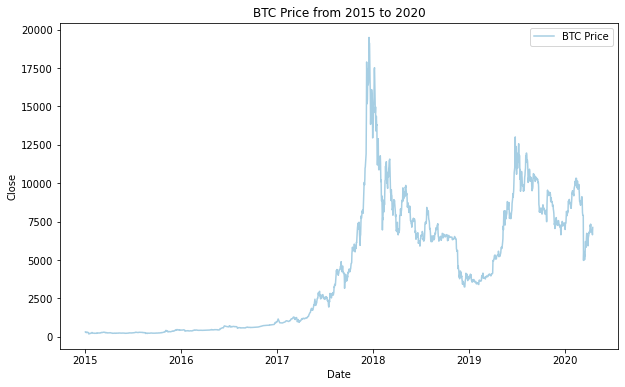

In [90]:
plt.figure(figsize=[10,6])
sns.set_palette("Paired")
sns.lineplot(data=selected_dates, x= 'Date', y='Close', label="BTC Price")
#sns.lineplot(data=occurrence, x= "date", y="rolling_occ", label="14 days rolling average")
plt.title("BTC Price from 2015 to 2020")

By comparing the BTC price figure and Frequency of BTC-related quotations figure from 2015 to 2020, we noticed that at the end of 2017 and the beginning of 2018, both figures have resembling trends. The number of quotations increases as the bitcoin price in general. This is the place where we can take future exploration of peoples's general attitude towards bitcoin and the topic of peoples's quotation, and then find our data stories.